In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

df = pd.read_csv("KDDTrain+.txt", header=None)
df_test = pd.read_csv("KDDTest+.txt", header=None)

In [3]:
df.drop(columns=[20], inplace=True)
df_test.drop(columns=[20], inplace=True)

categorical_cols = [1, 2, 3]
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[categorical_cols]).toarray()
encoded_test = encoder.transform(df_test[categorical_cols]).toarray()

df_encoded = np.concatenate([encoded, df.drop(columns=categorical_cols).drop(columns=[41], axis=1).values], axis=1)
df_test_encoded = np.concatenate([encoded_test, df_test.drop(columns=categorical_cols).drop(columns=[41], axis=1).values], axis=1)



In [4]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df_encoded)
X_test = scaler.transform(df_test_encoded)

y_train = df[41].apply(lambda x: 0 if x == 'normal' else 1).values
y_test = df_test[41].apply(lambda x: 0 if x == 'normal' else 1).values

In [5]:
def build_ssae():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    encoded = tf.keras.layers.Dense(100, activation='sigmoid')(inputs)
    encoded = tf.keras.layers.Dense(85, activation='sigmoid')(encoded)
    encoded = tf.keras.layers.Dense(55, activation='sigmoid')(encoded)
    bottleneck = tf.keras.layers.Dense(5, activation='sigmoid')(encoded)

    decoded = tf.keras.layers.Dense(55, activation='sigmoid')(bottleneck)
    decoded = tf.keras.layers.Dense(85, activation='sigmoid')(decoded)
    decoded = tf.keras.layers.Dense(100, activation='sigmoid')(decoded)
    outputs = tf.keras.layers.Dense(X_train.shape[1], activation='sigmoid')(decoded)

    autoencoder = tf.keras.Model(inputs, outputs)
    encoder_model = tf.keras.Model(inputs, bottleneck)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder_model

autoencoder, encoder_model = build_ssae()
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test), verbose=1)

Epoch 1/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0500 - val_loss: 0.0354
Epoch 2/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0349 - val_loss: 0.0355
Epoch 3/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0350 - val_loss: 0.0351
Epoch 4/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0349 - val_loss: 0.0349
Epoch 5/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0335 - val_loss: 0.0164
Epoch 6/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0116 - val_loss: 0.0136
Epoch 7/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0091 - val_loss: 0.0129
Epoch 8/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0081 - val_loss: 0.0122
Epoch 9/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0075 - val_loss: 0.0119
Epoch 10/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0072 - val_loss: 0.0117
Epoch 11/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0068 - val_loss: 0.0114
Epoch 12/50
985/985 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = []

print("\nStarting 5-Fold Cross-Validation using SSAE+SVM...\n")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\n--- Fold {fold} ---")

    X_fold_raw_train, X_fold_raw_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    X_fold_train_encoded = encoder_model.predict(X_fold_raw_train)
    X_fold_val_encoded = encoder_model.predict(X_fold_raw_val)

    svm = SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced')
    svm.fit(X_fold_train_encoded, y_fold_train)
    y_pred = svm.predict(X_fold_val_encoded)

    acc = accuracy_score(y_fold_val, y_pred)
    acc_scores.append(acc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(classification_report(y_fold_val, y_pred, digits=4))

    if fold == 5:
        final_y_true = y_fold_val
        final_y_pred = y_pred

print("\nAverage Cross-Validation Accuracy: {:.4f}".format(np.mean(acc_scores)))



Starting 5-Fold Cross-Validation using SSAE+SVM...


--- Fold 1 ---
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 Accuracy: 0.8842
              precision    recall  f1-score   support

           0     0.8482    0.9542    0.8981     13469
           1     0.9386    0.8039    0.8660     11726

    accuracy                         0.8842     25195
   macro avg     0.8934    0.8790    0.8820     25195
weighted avg     0.8903    0.8842    0.8832     25195


--- Fold 2 ---
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 2 Accuracy: 0.8820
              precision    recall  f1-score   support

           0     0.8445    0.9553    0.8965     13469
           1     0.9395    0.7979    0.8629     11726

    accuracy                         0.8820     25195
   macro avg     0.8920    0.8766    0.8797     25195
weighted avg     0.8887    0.8820    0.8809     25195


--- Fold 3 ---
3150/3150 ━━━━━━━━━━━━━━━━━━━

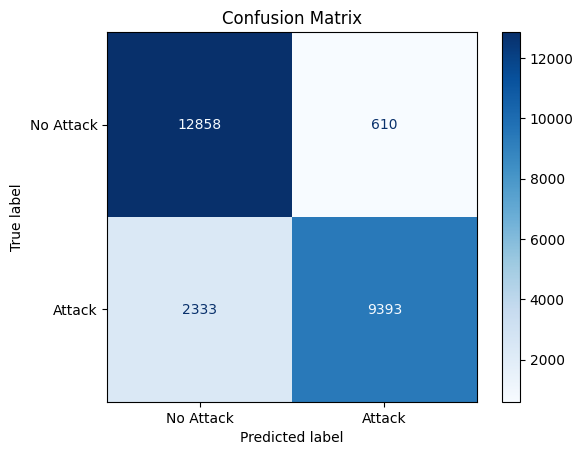

In [8]:
import matplotlib.pyplot as plt

cm = confusion_matrix(final_y_true, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Attack', 'Attack'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()